# 23.03 Guided Example

### Gradient Boost Guided Example

Having walked through gradient boost by hand in notebook 23.02, try it with SKLearn.  You'll use the same European Social Survey Data, but now with a categorical outcome.  Whether or not someone lives with a partner. 

In [1]:
import scipy
import time

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn import ensemble 
from sklearn import datasets 
from sklearn.utils import shuffle 
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
        "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

In [3]:
# Define outcome and predictors
# Set the outcome to 0 and 1
y = df["partner"] -1
X = df.loc[:,~df.columns.isin(["partner","cntry","idno"])]

# Make the categorical variable "country" into dummies 
X = pd.concat([X, pd.get_dummies(df["cntry"])], axis=1)

# Create training and test sets
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set 
X_test, y_test = X[offset:], y[offset:]

Since you're working with a binary outcome, you'll switch to a classifier.  Now your loss function can't be the residuals.  The options are "deviance" or "exponential".  deviance is used for logistic regression, you'll try that here.

In [4]:
# Make 500 iterations, use 2-deep trees, and set the loss funciton
params = dict(
    n_estimators=500, 
    max_depth=2, 
    loss="deviance"
)

# Set a timer to check runtime
start = time.time()

# Initialize and fit the model
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

# Print the fittin runtime
print(f"Runtime: {time.time() - start:0.2f} sec.")

predict_train = clf.predict(X_train) 
predict_test = clf.predict(X_test)

# Get the scores for later comparison
m1 = clf.score(X_test,y_test)

# Accuracy tables 
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc["All","All"]
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc["All","All"]

test_tI_errors = table_test.loc[0.0,1.0] / table_test.loc["All","All"]
test_tII_errors = table_test.loc[1.0,0.0] / table_test.loc["All","All"]

print(f"""
Training set accuracy: 
Percent Type I errors: {train_tI_errors}
Percent Type II errors: {train_tII_errors}\n
Test set accuracy: 
Percent Type I errors: {test_tI_errors}
Percent Type II errors: {test_tII_errors}\n
""")

Runtime: 2.99 sec.

Training set accuracy: 
Percent Type I errors: 0.04650845608292417
Percent Type II errors: 0.17607746863066012

Test set accuracy: 
Percent Type I errors: 0.06257668711656442
Percent Type II errors: 0.18527607361963191




Unlike decision trees, gradient boost solutions are not terribly easy to interpret on the surface.  But they aren't quite a black box.  You can get a measure of how important various features are by counting how many times a feature is used over the course of many decision trees.

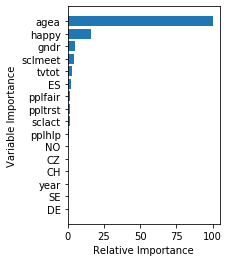

In [5]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5

plt.subplot(1,2,2)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel("Relative Importance")
plt.ylabel("Variable Importance") 
plt.show();

As you can see, it appears that age and happiness are the most important features in predicting whehter or not someone lives with a partner.

### DRILL: Improve this gradient boost model

While this model is already doing alright, we've seen from the Type I and Type II error rates that there is definitely room for improvement.  Your task is to see how low you can get the error rates to go in the test set, based on your model in the training set.  Strategies you might use include:

* Creating new features
* Applying more overfitting-prevention strategies like subsampling
* More iterations
* Trying a different loss function
* Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications

Have fun!

In [6]:

# Plot a correlaiton matrix
def corr_plot(corr_mat,figsize):
    """
        Pass in a correlation matrix and figsize (as a tuple) and plot the corresponding heatmap.
    """
    plt.figure(figsize=figsize)

    sns.heatmap(corr_mat, square=True, annot=True, linewidth=0.5)
    plt.title(f"Correlation matrix of winsorized variables")

    # Fix display issues for this version of matplotlib
    b,t = plt.ylim()
    b += 0.5
    t -= 0.5
    plt.ylim(b,t)
    # plt.yticks(rotation=360)

    plt.show();

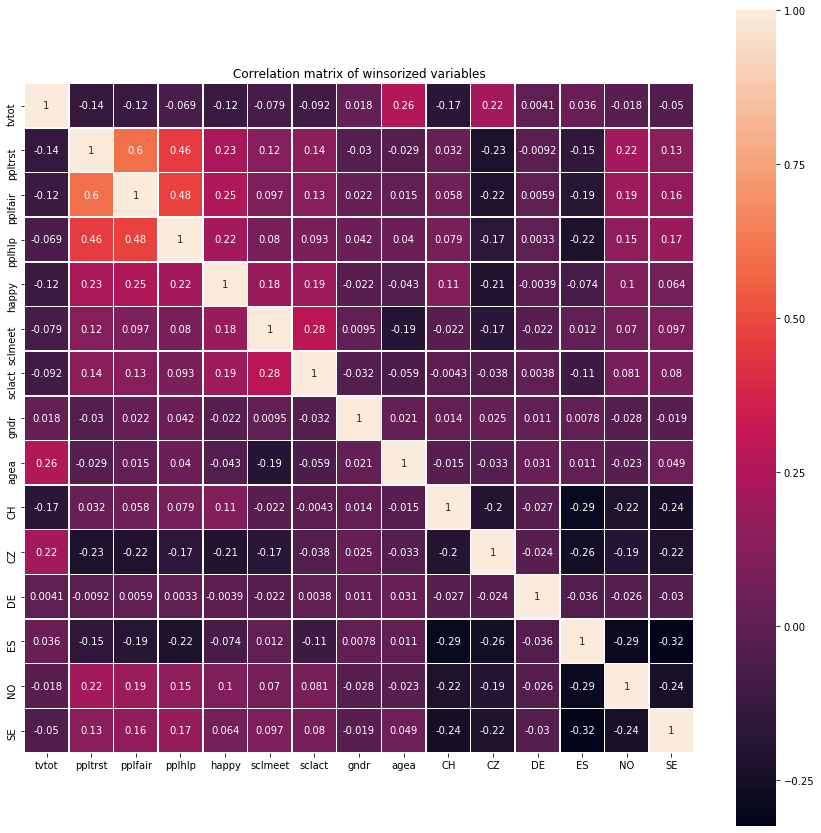

In [7]:
# Take a look at correlations between the top features to look for engineering opportunities
corr_matrix = X.corr()

# Get a column count to set the figure size
col_count = len(corr_matrix.iloc[1:,1:].columns)

# Plot the correlation matrix
corr_plot(corr_matrix.iloc[1:,1:],(col_count,col_count))

In [8]:
# Combine the "ppltrst", "pplfair", & "pplhlp" into an new feature: pplnice
X["pplnice"] = X["ppltrst"]*X["pplfair"]*X["pplhlp"]

# Now drop the "ppltrst", "pplfair", & "pplhlp" cols in favor of pplnice
X = X.loc[:,~X.columns.isin(["ppltrst","pplfair","pplhlp"])]

In [9]:
# Define outcome and predictors
# There is no change in y
# X was redefined above

# Create training and test sets 
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set 
X_train, y_train = X[offset:], y[offset:]

# And put 10% in the test set 
X_test, y_test = X[offset:], y[offset:]

In [10]:
# Make 800 iterations, use 4-deep trees, and set the loss function 
params = dict(
    n_estimators=800,
    max_depth=4, 
    subsample=0.5, 
    min_weight_fraction_leaf=0.2,
    learning_rate=0.05,
    min_samples_split=0.2,
    loss="deviance"
)

# Set a timer to check fitting runtime
start = time.time()

# Initialize and fit the model
clf=ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train) 

# Check to see how long the fitting took
print(f"Runtime: {time.time() - start:0.2f} sec.")

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test) 

# Accuracy tables 
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True) 

# Get the R^2 for the train and test
score_train = clf.score(X_train, y_train)
score_test = clf.score(X_test, y_test)

# Get the test scores for later comparison
m2 = clf.score(X_test, y_test)

# If you need a reminder about type errors: https://www.abtasty.com/blog/type-1-and-type-2-errors/
train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc["All","All"]
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc["All","All"] 

test_tI_errors = table_test.loc[0.0,1.0] / table_test.loc["All","All"]
test_tII_errors = table_test.loc[1.0,0.0] / table_test.loc["All","All"]

print(f"""
MODEL 2
{"="*80}
Training set accuracy:
R^2:                    {score_train} 
{"-"*80}
Percent Type I errors:  {train_tI_errors}
{"-"*80}
Percent Type II errors: {train_tII_errors}\n
Test set accuracy: 
R^2:                    {score_test}
{"-"*80}
Percent Type I errors:  {test_tI_errors}
{"-"*80}
Percent Type II errors: {test_tII_errors}\n
""")

Runtime: 0.64 sec.

MODEL 2
Training set accuracy:
R^2:                    0.7938650306748466 
--------------------------------------------------------------------------------
Percent Type I errors:  0.06748466257668712
--------------------------------------------------------------------------------
Percent Type II errors: 0.13865030674846626

Test set accuracy: 
R^2:                    0.7938650306748466
--------------------------------------------------------------------------------
Percent Type I errors:  0.06748466257668712
--------------------------------------------------------------------------------
Percent Type II errors: 0.13865030674846626




In [11]:
# Run a PCA to see how well the features of X are explaining the variance

# Instantiate PCA, setting the number of features
pca = PCA(n_components=len(X.columns))

# Return an array of transformed values
pca.fit_transform(X)

print(f"The percentage of total variance in the dataset explained by each component from PCA: ")
for i,val in enumerate(pca.explained_variance_ratio_):
    print(f"\t{list(X.columns)[i]:>8}: {val*100:0.3f}%")

The percentage of total variance in the dataset explained by each component from PCA: 
	    year: 98.869%
	   tvtot: 1.096%
	   happy: 0.012%
	 sclmeet: 0.009%
	  sclact: 0.006%
	    gndr: 0.002%
	    agea: 0.001%
	      CH: 0.001%
	      CZ: 0.001%
	      DE: 0.001%
	      ES: 0.001%
	      NO: 0.000%
	      SE: 0.000%
	 pplnice: 0.000%


As you can see most of the variance can be explained by the the first five features.  I'll adjust the model and see if there is an imporvement.

In [12]:
# Define outcome and predictors
# There is no change in y
X = X.iloc[:,:5]

# Create training and test sets 
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set 
X_train, y_train = X[offset:], y[offset:]

# And put 10% in the test set 
X_test, y_test = X[offset:], y[offset:]

In [13]:
# Make 800 iterations, use 4-deep trees, and set the loss function 
params = dict(
    n_estimators=800,
    max_depth=4, 
    subsample=0.5, 
    min_weight_fraction_leaf=0.2,
    learning_rate=0.05,
    min_samples_split=0.2,
    loss="deviance"
)

# Set a timer to check fitting runtime
start = time.time()

# Initialize and fit the model
clf=ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train) 

# Check to see how long the fitting took
print(f"Runtime: {time.time() - start:0.2f} sec.")

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test) 

# Accuracy tables 
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True) 

# Get the R^2 for the train and test
score_train = clf.score(X_train, y_train)
score_test = clf.score(X_test, y_test)

# Get the test scores for later comparison
m3 = clf.score(X_test,y_test) 

# If you need a reminder about type errors: https://www.abtasty.com/blog/type-1-and-type-2-errors/
train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc["All","All"]
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc["All","All"] 

test_tI_errors = table_test.loc[0.0,1.0] / table_test.loc["All","All"]
test_tII_errors = table_test.loc[1.0,0.0] / table_test.loc["All","All"]

print(f"""
MODEL 3
{"="*80}
Training set accuracy:
R^2:                    {score_train} 
{"-"*80}
Percent Type I errors:  {train_tI_errors}
{"-"*80}
Percent Type II errors: {train_tII_errors}\n
Test set accuracy: 
R^2:                    {score_test}
{"-"*80}
Percent Type I errors:  {test_tI_errors}
{"-"*80}
Percent Type II errors: {test_tII_errors}\n
""")

Runtime: 0.56 sec.

MODEL 3
Training set accuracy:
R^2:                    0.6638036809815951 
--------------------------------------------------------------------------------
Percent Type I errors:  0.12147239263803682
--------------------------------------------------------------------------------
Percent Type II errors: 0.2147239263803681

Test set accuracy: 
R^2:                    0.6638036809815951
--------------------------------------------------------------------------------
Percent Type I errors:  0.12147239263803682
--------------------------------------------------------------------------------
Percent Type II errors: 0.2147239263803681




In [14]:
# Print the model scores for comparison
print(f"Model 1: {m1}")
print(f"Model 2: {m2}")
print(f"Model 3: {m3}")

Model 1: 0.7521472392638037
Model 2: 0.7938650306748466
Model 3: 0.6638036809815951


As you can see, Model 2 appears to be the most performant.